In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '2'

import warnings
warnings.filterwarnings("ignore")

import sys
sys.path.append("/xfs/home/tensor_zy/guoxuan/Task3/ChatGLM/inferencing")

In [2]:
from transformers import AutoModel, AutoTokenizer
from sklearn.metrics import accuracy_score,f1_score,roc_auc_score,recall_score,precision_score, auc
from tqdm import tqdm
import pandas as pd
import json, torch

from cover_alpaca2jsonl import format_example

In [3]:
model_path = "THUDM/chatglm2-6b"
tokenizer = AutoTokenizer.from_pretrained(model_path, trust_remote_code=True)
# model = AutoModel.from_pretrained(model_path, trust_remote_code=True, load_in_8bit=True, device = "cuda")
model = AutoModel.from_pretrained(model_path, trust_remote_code=True, load_in_8bit=True, device_map = "auto")

from peft import PeftModel
peft_path = "../../finetuned_model/"
model = PeftModel.from_pretrained(model, peft_path)

# model = AutoModel.from_pretrained(model_path, trust_remote_code=True, device_map = "auto")
model = torch.compile(model)
model = model.eval()

[2023-07-26 19:35:43,179] [INFO] [real_accelerator.py:110:get_accelerator] Setting ds_accelerator to cuda (auto detect)

===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please run

python -m bitsandbytes

 and submit this information together with your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
bin /xfs/home/tensor_zy/anaconda3/lib/python3.8/site-packages/bitsandbytes/libbitsandbytes_cuda110.so
CUDA SETUP: CUDA runtime path found: /xfs/home/tensor_zy/anaconda3/envs/isaacgym/lib/libcudart.so.11.0
CUDA SETUP: Highest compute capability among GPUs detected: 8.0
CUDA SETUP: Detected CUDA version 110
CUDA SETUP: Loading binary /xfs/home/tensor_zy/anaconda3/lib/python3.8/site-packages/bitsandbytes/libbitsandbytes_cuda110.so...


The model weights are not tied. Please use the `tie_weights` method before using the `infer_auto_device` function.


Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

### Load Dataset

In [4]:
from datasets import load_dataset
import datasets

dataset = load_dataset("piqa")
dataset = dataset['validation']
dataset

Found cached dataset piqa (/xfs/home/tensor_zy/.cache/huggingface/datasets/piqa/plain_text/1.1.0/6c611c1a9bf220943c4174e117d3b660859665baf1d43156230116185312d011)


  0%|          | 0/3 [00:00<?, ?it/s]

Dataset({
    features: ['goal', 'sol1', 'sol2', 'label'],
    num_rows: 1838
})

In [5]:
dataset = dataset.to_pandas()
dataset['instruction'] = 'Please choose the best answer from the two options.'
dataset['input'] = dataset.apply(lambda x:x['goal'] + " {" + x['sol1']+"/"+x["sol2"]+"}.",axis = 1)
dataset['output'] = dataset.apply(lambda x:x['sol1'] if x['label'] == 0 else x['sol2'], axis = 1)
dataset.head(2)

,goal,sol1,sol2,label,instruction,input,output
0,How do I ready a guinea pig cage for it's new ...,Provide the guinea pig with a cage full of a f...,Provide the guinea pig with a cage full of a f...,0,Please choose the best answer from the two opt...,How do I ready a guinea pig cage for it's new ...,Provide the guinea pig with a cage full of a f...
1,dresser,replace drawer with bobby pin,"finish, woodgrain with bobby pin",1,Please choose the best answer from the two opt...,dresser {replace drawer with bobby pin /finish...,"finish, woodgrain with bobby pin"


In [6]:
dataset[["context","target"]] = dataset.apply(format_example, axis = 1, result_type="expand")
dataset.head(2)

,goal,sol1,sol2,label,instruction,input,output,context,target
0,How do I ready a guinea pig cage for it's new ...,Provide the guinea pig with a cage full of a f...,Provide the guinea pig with a cage full of a f...,0,Please choose the best answer from the two opt...,How do I ready a guinea pig cage for it's new ...,Provide the guinea pig with a cage full of a f...,Instruction: Please choose the best answer fro...,Provide the guinea pig with a cage full of a f...
1,dresser,replace drawer with bobby pin,"finish, woodgrain with bobby pin",1,Please choose the best answer from the two opt...,dresser {replace drawer with bobby pin /finish...,"finish, woodgrain with bobby pin",Instruction: Please choose the best answer fro...,"finish, woodgrain with bobby pin"


In [7]:
context = dataset['context'].tolist()
len(context)

1838

In [8]:
batch_size = 64

total_steps = dataset.shape[0]//batch_size
total_steps

28

In [9]:
res_list = []
res_sentences_list = []
out_text_list = []

for i in tqdm(range(total_steps+1)):
    tmp_context = context[i* batch_size:(i+1)* batch_size]
    tokens = tokenizer(tmp_context, return_tensors='pt', padding=True, max_length=512)
    for k in tokens.keys():
        tokens[k] = tokens[k].cuda()
    
    res = model.generate(**tokens, max_length=512)
    res_sentences = [tokenizer.decode(i) for i in res]
    out_text = [o.split("Answer: ")[1] for o in res_sentences]
    res_list += res
    res_sentences_list += res_sentences
    out_text_list += out_text
    torch.cuda.empty_cache()

100%|██████████| 29/29 [08:01<00:00, 16.60s/it]


In [10]:
res_list = [i.cpu() for i in res_list]

In [11]:
dataset["res"] = res_list
dataset["res_sentences"] = res_sentences_list
dataset["out_text"] = out_text_list

In [25]:
dataset['sol1_token'] = dataset['sol1'].apply(lambda x: tokenizer.encode(x))
dataset['sol2_token'] = dataset['sol2'].apply(lambda x: tokenizer.encode(x))
dataset['out_token'] = dataset['out_text'].apply(lambda x: tokenizer.encode(x))

In [29]:
import difflib

In [38]:
dataset['sol1_score'] = dataset.apply(lambda x: difflib.SequenceMatcher(None, x['sol1_token'], x['out_token']).ratio(), axis = 1)
dataset['sol2_score'] = dataset.apply(lambda x: difflib.SequenceMatcher(None, x['sol2_token'], x['out_token']).ratio(), axis = 1)
dataset['new_out'] = dataset.apply(lambda x:0 if x['sol1_score'] > x['sol2_score'] else 1, axis = 1)
dataset[['sol1_score', 'sol2_score', 'new_out']]

,sol1_score,sol2_score,new_out
0,0.951220,0.902439,0
1,0.842105,0.521739,0
2,0.833333,0.181818,0
3,0.740741,0.888889,1
4,0.888889,0.814815,0
...,...,...,...
1833,0.924731,0.957447,1
1834,0.888889,0.571429,0
1835,0.955224,0.925373,0
1836,0.538462,0.888889,1


In [34]:
dataset['target']

0       Provide the guinea pig with a cage full of a f...
1                      finish, woodgrain with  bobby pin 
2       You have to defeat Apollo Creed and Clubber La...
3           Blow into trash bag and tie with rubber band.
4          will turn into a cooler if you add water to it
                              ...                        
1833    Chop the chocolate into small chunks. Bring th...
1834                 Peel the oranges and put in blender.
1835    Create a fire using wood. Poke a marshmallow w...
1836       can clean an aging cruise liner clear of grime
1837    You can purchase a tennis ball at any sports s...
Name: target, Length: 1838, dtype: object

<AxesSubplot:>

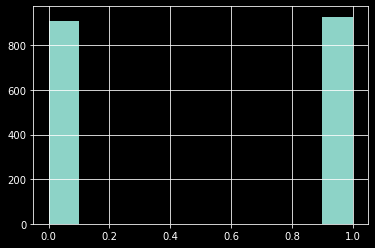

In [35]:
dataset["new_target"] = dataset["label"]
dataset["new_target"].hist()

<AxesSubplot:>

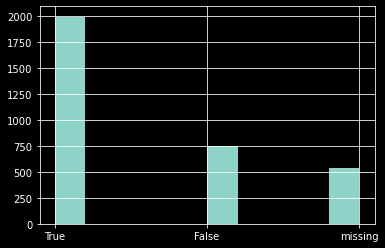

In [ ]:
dataset["new_out"] = dataset["out_text"].apply(change_target)
dataset["new_out"].hist()

### 8-bit

In [39]:
acc = accuracy_score(dataset["new_target"], dataset["new_out"])
acc

0.6180631120783461

In [40]:
f1 = f1_score(dataset["new_target"], dataset["new_out"], average = "macro")
f1

0.6173381686697249

In [41]:
f1 = f1_score(dataset["new_target"], dataset["new_out"], average = "micro")
f1

0.6180631120783461

In [42]:
f1 = f1_score(dataset["new_target"], dataset["new_out"], average = "weighted")
f1

0.6175012809366646

### Full

In [21]:
acc = accuracy_score(dataset["new_target"], dataset["new_out"])
acc

0.8327272727272728

In [22]:
f1 = f1_score(dataset["new_target"], dataset["new_out"], average = "macro")
f1

0.569713523470749

In [23]:
f1 = f1_score(dataset["new_target"], dataset["new_out"], average = "micro")
f1

0.8327272727272728

In [24]:
f1 = f1_score(dataset["new_target"], dataset["new_out"], average = "weighted")
f1

0.8010500482176782

In [27]:
dataset.to_csv("fiqa_ori.csv")

: 